In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


In [31]:

df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')  # Replace 'Data' if your sheet has a different name

print(df.head())
print(df.info())
print(df.describe())


   ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total

In [32]:
# Check for missing values
print(df.isnull().sum())
df['Experience'] = df['Experience'].apply(lambda x: max(x, 0))
df = df.dropna()  
df['Education'] = df['Education'].astype('category')
df = pd.get_dummies(df, columns=['Education'], drop_first=True)

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64


# Exploratory Data Analysis (EDA)

In [33]:
numerical_features = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
target = 'Personal Loan'
print(df[numerical_features + [target]].describe())

               Age   Experience       Income        CCAvg     Mortgage  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     45.338400    20.119600    73.774200     1.937913    56.498800   
std      11.463166    11.440484    46.033729     1.747666   101.713802   
min      23.000000     0.000000     8.000000     0.000000     0.000000   
25%      35.000000    10.000000    39.000000     0.700000     0.000000   
50%      45.000000    20.000000    64.000000     1.500000     0.000000   
75%      55.000000    30.000000    98.000000     2.500000   101.000000   
max      67.000000    43.000000   224.000000    10.000000   635.000000   

       Personal Loan  
count    5000.000000  
mean        0.096000  
std         0.294621  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  


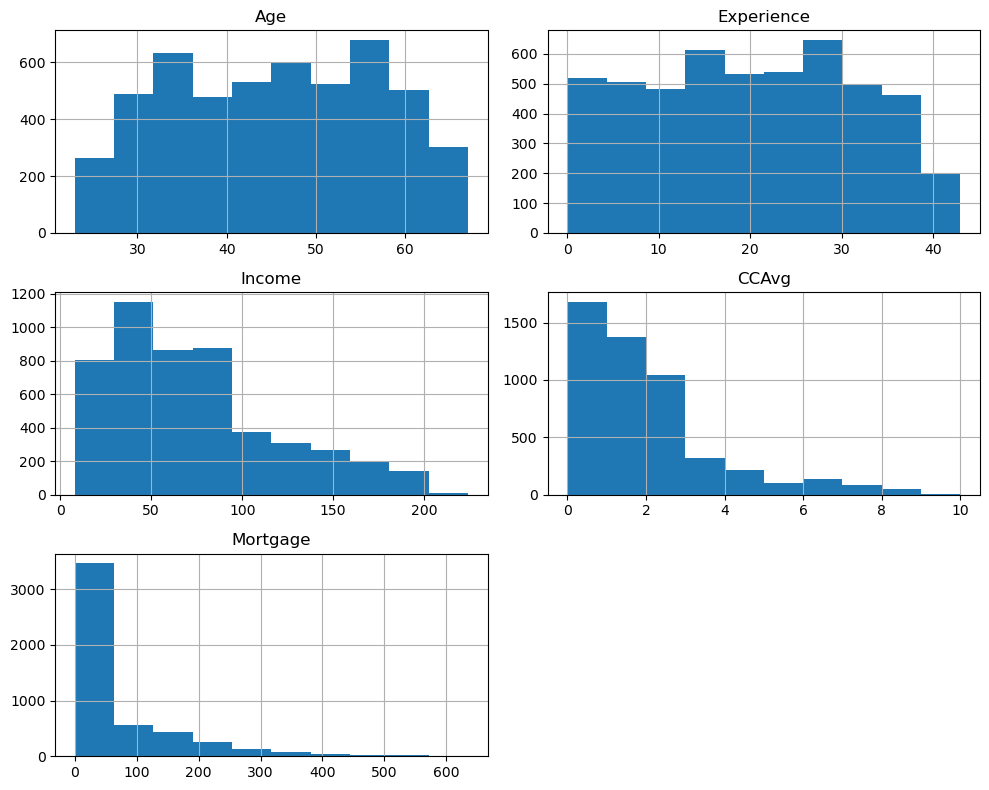

In [34]:
# Histograms for numerical features
df[numerical_features].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()


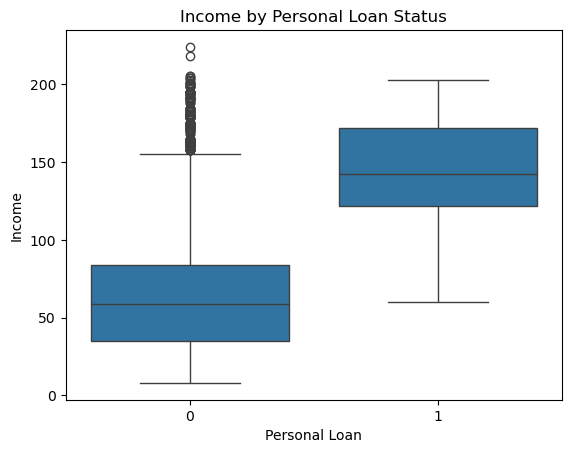

In [35]:
sns.boxplot(x=target, y='Income', data=df)
plt.title('Income by Personal Loan Status')
plt.show()

Loan Acceptance Rate: 9.60%


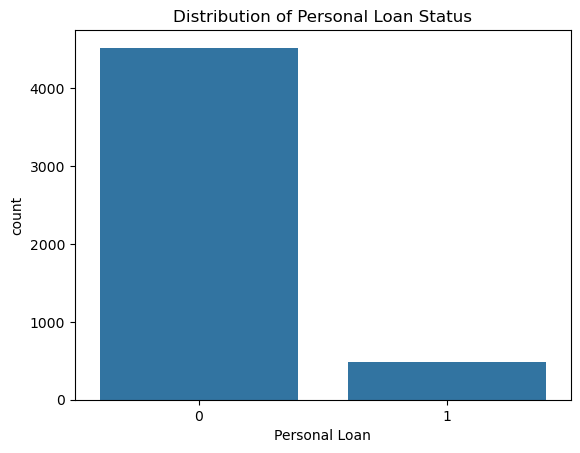

In [36]:
# Target distribution
loan_rate = (df[target].sum() / len(df)) * 100
print(f"Loan Acceptance Rate: {loan_rate:.2f}%")
sns.countplot(x=target, data=df)
plt.title('Distribution of Personal Loan Status')
plt.show()

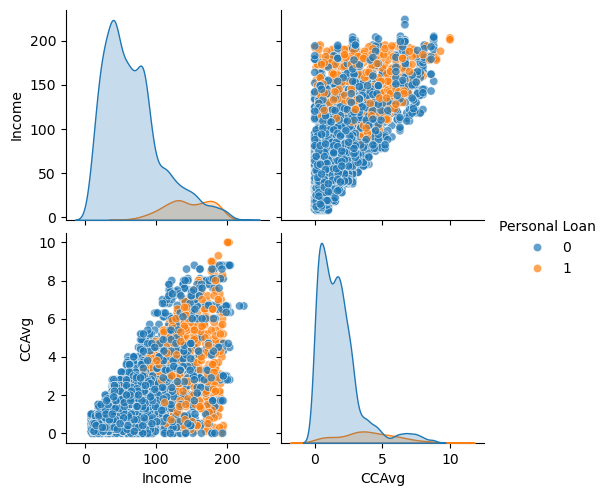

In [37]:
# Pairplot: Income vs. CCAvg by Loan status
sns.pairplot(df, vars=['Income', 'CCAvg'], hue=target, plot_kws={'alpha':0.7})
plt.show()

# Correlation & Key Drivers

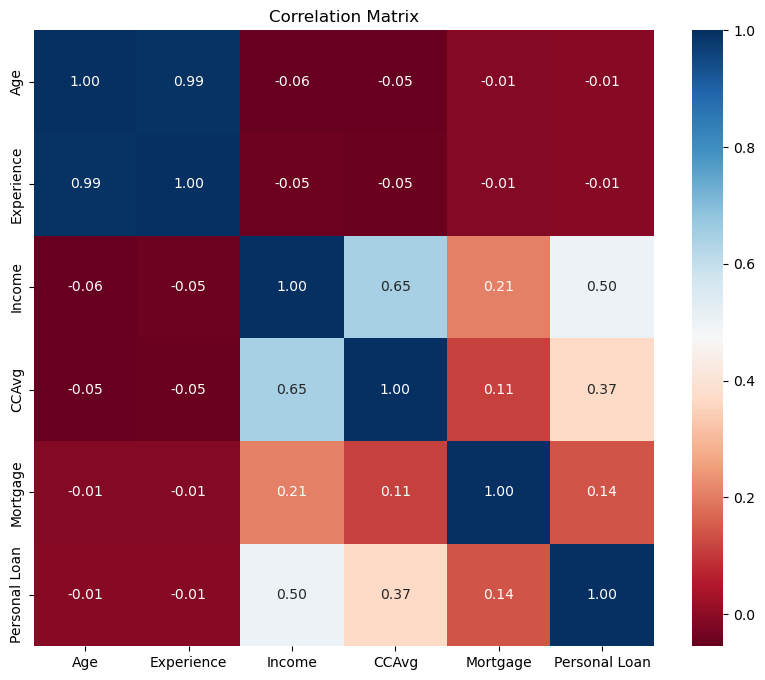

In [38]:
# Correlation matrix 
corr = df[numerical_features + [target]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu')
plt.title("Correlation Matrix")
plt.show()

In [47]:

for col in numerical_features:
    contingency = pd.crosstab(df[col], df[target])
    chi2, p, dof, ex = chi2_contingency(contingency)
    print(f"Chi-squared test for {col}: p-value = {p:.5f}")

for col in numerical_features:
    group0 = df[df[target]==0][col]
    group1 = df[df[target]==1][col]
    f_stat, p = f_oneway(group0, group1)
    print(f"ANOVA for {col}: p-value = {p:.5f}")


Chi-squared test for Age: p-value = 0.12013
Chi-squared test for Experience: p-value = 0.74167
Chi-squared test for Income: p-value = 0.00000
Chi-squared test for CCAvg: p-value = 0.00000
Chi-squared test for Mortgage: p-value = 0.00000
ANOVA for Age: p-value = 0.58496
ANOVA for Experience: p-value = 0.57853
ANOVA for Income: p-value = 0.00000
ANOVA for CCAvg: p-value = 0.00000
ANOVA for Mortgage: p-value = 0.00000


In [48]:
X = df.drop([target, 'ID', 'ZIP Code'], axis=1, errors='ignore')
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))

Logistic Regression Accuracy: 0.967
Confusion Matrix:
 [[887   8]
 [ 25  80]]
ROC-AUC: 0.9760574620909817


Decision Tree Accuracy: 0.984
Confusion Matrix:
 [[893   2]
 [ 14  91]]
ROC-AUC: 0.9931098696461825


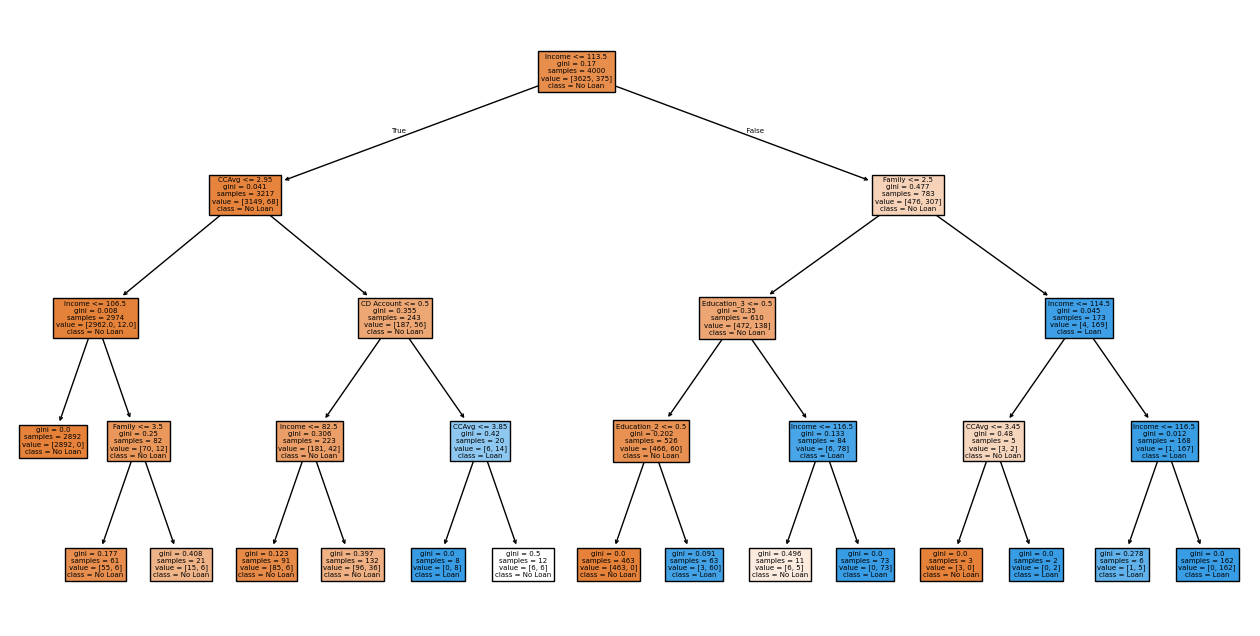

In [49]:
# Decision Tree
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print("ROC-AUC:", roc_auc_score(y_test, tree_clf.predict_proba(X_test)[:,1]))

# Plot Decision Tree
plt.figure(figsize=(16,8))
plot_tree(tree_clf, filled=True, feature_names=X.columns, class_names=['No Loan', 'Loan'])
plt.show()

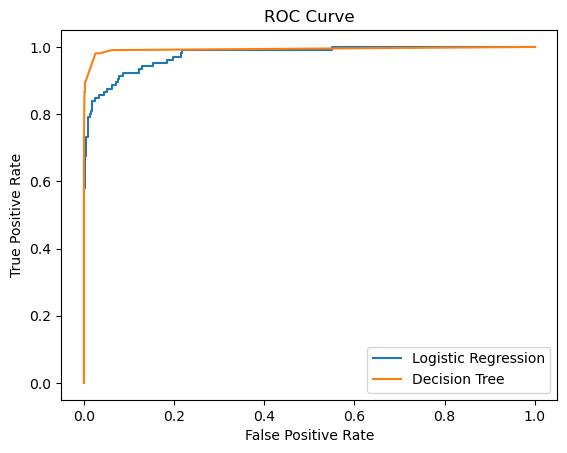

In [50]:
# Plot ROC curve
fpr1, tpr1, _ = roc_curve(y_test, lr.predict_proba(X_test_scaled)[:,1])
fpr2, tpr2, _ = roc_curve(y_test, tree_clf.predict_proba(X_test)[:,1])
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Decision Tree')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [53]:
# Save the final cleaned/processed data at the end
df.to_excel("cleaned_loan_data.xlsx", index=False)
# Optional CSV version
df.to_csv("cleaned_loan_data.csv", index=False)
